# Image generation with DeepFloyd IF and OpenVINO™

DeepFloyd IF is an advanced open-source text-to-image model that delivers remarkable photorealism and language comprehension. DeepFloyd IF consists of a frozen text encoder and three cascaded pixel diffusion modules: a base model that creates 64x64 px images based on text prompts and two super-resolution models, each designed to generate images with increasing resolution: 256x256 px and 1024x1024 px. All stages of the model employ a frozen text encoder, built on the T5 transformer, to derive text embeddings, which are then passed to a UNet architecture enhanced with cross-attention and attention pooling.

![deepfloyd_if_scheme](https://github.com/deep-floyd/IF/raw/develop/pics/deepfloyd_if_scheme.jpg)


## Prerequisites
Install required packages.

In [39]:
%%bash
# Set up requirements

pip install --upgrade pip
pip install deepfloyd_if==1.0.2rc0
pip install xformers==0.0.16
pip install git+https://github.com/openai/CLIP.git --no-deps
pip install huggingface_hub
pip install --upgrade diffusers accelerate transformers safetensors
# pip install openvino-dev==2023.0.0.dev20230407
pip install openvino-dev==2023.0.0.dev20230427

  Using cached transformers-4.25.1-py3-none-any.whl (5.8 MB)
  Using cached accelerate-0.15.0-py3-none-any.whl (191 kB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.28.1
    Uninstalling transformers-4.28.1:
      Successfully uninstalled transformers-4.28.1
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.19.0
    Uninstalling accelerate-0.19.0:
      Successfully uninstalled accelerate-0.19.0


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-dc97emcl


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-dc97emcl


  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached accelerate-0.19.0-py3-none-any.whl (219 kB)
  Using cached transformers-4.28.1-py3-none-any.whl (7.0 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.25.1
    Uninstalling transformers-4.25.1:
      Successfully uninstalled transformers-4.25.1
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.15.0
    Uninstalling accelerate-0.15.0:
      Successfully uninstalled accelerate-0.15.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
deepfloyd-if 1.0.2rc0 requires accelerate~=0.15.0, but you have accelerate 0.19.0 which is incompatible.
deepfloyd-if 1.0.2rc0 requires transformers~=4.25.1, but you have transformers 4.28.1 which is incompatible.


In [4]:
import gc
import os
from pathlib import Path
from typing import Union, List

import diffusers
from diffusers import DiffusionPipeline
from diffusers.utils import pt_to_pil
from openvino.runtime import Core, PartialShape, serialize
from openvino.tools import mo
from openvino.tools.mo.convert import InputCutInfo
import torch

In [5]:
# Set up target computing device
DEVICE = 'CPU'  # 'GPU' is also an option

if DEVICE=='CPU':
    checkpoint_variant = 'fp32'
    model_dtype = torch.float32
    ir_input_type = 'f32'
    compress_to_fp16 = False
elif DEVICE=='GPU':
    checkpoint_variant = 'fp32'
    model_dtype = torch.float32
    ir_input_type = 'f16'
    compress_to_fp16 = True

models_dir = Path('./models')
models_dir.mkdir(exist_ok=True)

encoder_ir_path = models_dir / 'encoder_ir.xml'
first_stage_unet_ir_path = models_dir / 'unet_ir_I_l.xml'
second_stage_unet_ir_path = models_dir / 'unet_ir_II_m.xml'

### Authentication
In order to access IF checkpoints, users need to provide an authentication token. To generate a token, follow the link displayed in the cell output.
Uncheck the `Add token as git credential?` box.

In [ ]:
from huggingface_hub import login

login()

## Stable Diffusion in Diffusers library
To work with IF by DeepFloyd Lab, we will use Hugging Face Diffusers library. To experiment with diffusion models, Diffusers exposes the DiffusionPipeline. The code below demonstrates how to create a DiffusionPipeline using IF configs:

In [6]:
%%time

#Downloading the model weights may take some time. The approximate total checkpoints size is 27GB.
stage_1 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-L-v1.0",
    variant=checkpoint_variant,
#     torch_dtype=model_dtype
)

stage_2 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-II-M-v1.0",
    text_encoder=None,
    variant=checkpoint_variant,
#     torch_dtype=model_dtype
)

The config attributes {'lambda_min_clipped': -5.1} were passed to DDPMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The config attributes {'lambda_min_clipped': -5.1} were passed to DDPMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


CPU times: user 1.52 s, sys: 138 ms, total: 1.66 s
Wall time: 10.3 s


## Convert models to OpenVINO Intermediate representation (IR) format
The OpenVINO Model Optimizer enables direct conversion of PyTorch models. We will utilize the mo.convert_model method to acquire OpenVINO IR versions of the models. This requires providing a model object, input data for model tracing, and other relevant parameters. The use_legacy_frontend=True parameter instructs the Model Optimizer to employ the ONNX model format as an intermediate step, as opposed to using the PyTorch JIT compiler, which is not optimal for our situation.

The pipeline consists of three important parts:

 - A Text Encoder that translates user prompts to vectors in the latent space that the Diffusion model can understand.
 - A Stage 1 U-Net for step-by-step denoising latent image representation.
 - A Stage 2 U-Net that takes low resolution output from the previous step and the latent representations to upscale the resulting image.
 
Let us convert each part

## 1. Convert Text Encoder

The text encoder is responsible for converting the input prompt, such as "ultra close-up color photo portrait of rainbow owl with deer horns in the woods" into an embedding space that can be fed to the next stage's U-Net. Typically, it is a transformer-based encoder that maps a sequence of input tokens to a sequence of text embeddings.

The input for the text encoder consists of a tensor `input_ids`, which contains token indices from the text processed by the tokenizer and padded to the maximum length accepted by the model, and `attention_mask`, which marks relevant tokens with 1s and padded tokens with 0s.

In [7]:
%%time

if not encoder_ir_path.exists():
    encoder_ir = mo.convert_model(
        stage_1.text_encoder,
        input=[InputCutInfo(shape=PartialShape([-1,77]), type='i32'),
               InputCutInfo(shape=PartialShape([-1,77]), type='i32')],
        compress_to_fp16=compress_to_fp16,
        progress=True,
    )
    
    # Serialize the IR model to disk, we will load it at inference time
    serialize(encoder_ir, encoder_ir_path)
    del encoder_ir
    
del stage_1.text_encoder
gc.collect();

CPU times: user 1min 50s, sys: 32.2 s, total: 2min 22s
Wall time: 52.7 s


## Convert the first Pixel Diffusion module's UNet

U-Net model gradually denoises latent image representation guided by text encoder hidden state.

U-Net model has three inputs:

`sample` - latent image sample from previous step. Generation process has not been started yet, so you will use random noise.
`timestep` - current scheduler step.
`encoder_hidden_state` - hidden state of text encoder.
Model predicts the sample state for the next step.

The first Diffusion module in the cascade generates 64x64 pixel low resolution images.

In [8]:
%%time

if not first_stage_unet_ir_path.exists():
    unet_1_ir = mo.convert_model(
        stage_1.unet,
        input=[InputCutInfo(shape=PartialShape([-1, 3, 64, 64]), type=ir_input_type),
               InputCutInfo(shape=PartialShape([]), type='i32'),
               InputCutInfo(shape=PartialShape([-1, 77, 4096]), type=ir_input_type)],
        compress_to_fp16=compress_to_fp16,
        progress=True,
    )

    serialize(unet_1_ir, first_stage_unet_ir_path)
    
    del unet_1_ir

stage_1_config = stage_1.unet.config
del stage_1.unet
gc.collect();

/home/idavidyu/.virtualenvs/if/lib/python3.10/site-packages/diffusers/models/unet_2d_condition.py:650: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if any(s % default_overall_up_factor != 0 for s in sample.shape[-2:]):
/home/idavidyu/.virtualenvs/if/lib/python3.10/site-packages/diffusers/models/resnet.py:200: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert hidden_states.shape[1] == self.channels
/home/idavidyu/.virtualenvs/if/lib/python3.10/site-packages/diffusers/models/resnet.py:205: TracerWarning: Converting a tensor to a Python boolean might 

CPU times: user 2min 41s, sys: 51.5 s, total: 3min 33s
Wall time: 1min 38s


## Convert the second pixel diffusion module

The second Diffusion module in the cascade generates 256x256 pixel images.

In [10]:
%%time

if not second_stage_unet_ir_path.exists():
    unet_2_ir = mo.convert_model(
        stage_2.unet,
        input=[InputCutInfo(shape=PartialShape([-1, 6, 256, 256]), type=ir_input_type),
               InputCutInfo(shape=PartialShape([]), type='i32'),
               InputCutInfo(shape=PartialShape([-1, 77, 4096]), type=ir_input_type),
               InputCutInfo(shape=PartialShape([-1]), type='i32'),],
        compress_to_fp16=compress_to_fp16,
        progress=True,
    )

    serialize(unet_2_ir, second_stage_unet_ir_path)
    
    del unet_2_ir
    
stage_2_config = stage_2.unet.config
del stage_2.unet
gc.collect();

CPU times: user 2min 44s, sys: 19.7 s, total: 3min 3s
Wall time: 20.4 s


## Prepare Inference pipeline

The original pipeline from the source repository will be reused in this example. In order to achieve this, adapter classes were created to enable OpenVINO models to replace Pytorch models and integrate seamlessly into the pipeline.

In [11]:
core = Core()

In [12]:
class TextEncoder:
    """
    Text Encoder Adapter Class.
    
    This class is designed to seamlessly integrate the OpenVINO compiled model into the `stage_1.encode_prompt` routine.
    """

    def __init__(self, ir_path: Union[str, Path], dtype: torch.dtype, device: str = 'CPU'):
        """Init the adapter with the IR model path."""
        self.ir_path = ir_path 
        self.dtype = dtype
        self.device = device
        
    def __call__(self, *args, **kwargs):
        """Adapt the network call."""
        self.encoder_openvino = core.compile_model(self.ir_path, self.device)
        try:
            result = self.encoder_openvino(list(args) + list(kwargs.values()))
            result_numpy = result[self.encoder_openvino.outputs[0]]
        finally:
            # Remove the encoder once it did its job
            del self.encoder_openvino
            gc.collect()
        return [torch.tensor(result_numpy, dtype=self.dtype)]

In [13]:
class UnetFirstStage:
    """
    IF Stage-1 Unet Adapter Class.
    
    This class is designed to seamlessly integrate the OpenVINO compiled model into
    the `stage_1` diffusion pipeline.
    """

    def __init__(self, unet_ir_path: Union[str, Path],
                 config: diffusers.configuration_utils.FrozenDict,
                 dtype: torch.dtype,
                 device: str = 'CPU'
                ):
        """Init the adapter with the IR model path and model config."""
        self.unet_openvino = core.compile_model(unet_ir_path, device)
        self.config = config
        self.dtype = dtype
        
    def __call__(self, *args, **kwargs):
        """Adapt the network call."""
        parameters = [*args, kwargs['encoder_hidden_states']]
        result = self.unet_openvino(parameters)
        result_numpy = result[self.unet_openvino.outputs[0]]
        # the stage 1 pipeline expects an object with a `sample` attribute
        class a:
            sample = torch.tensor(result_numpy, dtype=self.dtype)
        return a


class UnetSecondStage:
    """
    IF Stage-2 Unet Adapter Class.
    
    This class is designed to seamlessly integrate the OpenVINO compiled model into
    the `stage_2` diffusion pipeline.
    """

    def __init__(self, unet_ir_path: Union[str, Path],
                 config: diffusers.configuration_utils.FrozenDict,
                 dtype: torch.dtype,
                 device: str = 'CPU'
                ):
        """Init the adapter with the IR model path and model config."""
        self.unet_openvino = core.compile_model(unet_ir_path, device)
        self.config = config
        self.dtype = dtype
        
    def __call__(self, *args, **kwargs):
        """Adapt the network call."""
        parameters = [*args, kwargs['encoder_hidden_states'], kwargs['class_labels']]
        result = self.unet_openvino(parameters)
        result_numpy = result[self.unet_openvino.outputs[0]]
        # the stage 2 pipeline expects an object with a `sample` attribute
        class a:
            sample = torch.tensor(result_numpy, dtype=self.dtype)
        return a

## Run Text-to-Image generation

Now, we can set a text prompt for image generation and execute the inference pipeline. Optionally, you can also modify the random generator seed for latent state initialization and adjust the number of images to be generated for the given prompt.

In [14]:
%%time

stage_1.text_encoder = TextEncoder(encoder_ir_path, dtype=model_dtype)

CPU times: user 29 µs, sys: 7 µs, total: 36 µs
Wall time: 52.2 µs


In [15]:
%%time

prompt = 'uultra close-p color photo portrait of rainbow owl with deer horns in the woods'
count = 1

# text embeds
prompt_embeds, negative_embeds = stage_1.encode_prompt(prompt, num_images_per_prompt=count)

/home/idavidyu/.virtualenvs/if/lib/python3.10/site-packages/diffusers/configuration_utils.py:135: FutureWarning: Accessing config attribute `unet` directly via 'IFPipeline' object attribute is deprecated. Please access 'unet' over 'IFPipeline's config object instead, e.g. 'scheduler.config.unet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


CPU times: user 56.9 s, sys: 19.2 s, total: 1min 16s
Wall time: 10.2 s


In [16]:
%%time

stage_1.unet = UnetFirstStage(first_stage_unet_ir_path, stage_1_config, dtype=model_dtype)

CPU times: user 6.01 s, sys: 1.17 s, total: 7.18 s
Wall time: 5.69 s


  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 21min 52s, sys: 11.9 s, total: 22min 4s
Wall time: 1min 18s


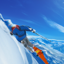

In [17]:
%%time

generator = torch.manual_seed(142)

image = stage_1(prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds, generator=generator, output_type="pt").images
pt_to_pil(image)[0]

In [18]:
%%time

stage_2.unet = UnetSecondStage(second_stage_unet_ir_path, stage_2_config, dtype=model_dtype)

CPU times: user 4.3 s, sys: 683 ms, total: 4.98 s
Wall time: 4.06 s


  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 27min 9s, sys: 8.19 s, total: 27min 17s
Wall time: 1min 41s


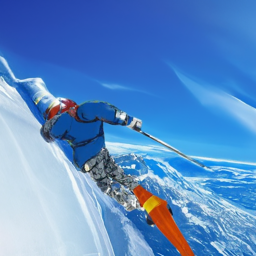

In [19]:
%%time

image = stage_2(
    image=image, prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds, generator=generator, output_type="pt"
).images
for i, im in enumerate(pt_to_pil(image)):
    im.save(f"./if_stage_II_ov_{i}.png")
pt_to_pil(image)[0]